# Feature Engineering
Chapter 4 of the book: "Build Your Own AI Investor"

In [1]:
from platform import python_version
print(python_version())

3.7.7


In [2]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [3]:
x_=pd.read_csv(\
       "Annual_Stock_Price_Fundamentals_Filtered.csv",\
       index_col=0)
y_=pd.read_csv(\
       "Annual_Stock_Price_Performance_Filtered.csv",\
       index_col=0)

In [3]:
keyCheckNullList = ["Short Term Debt" ,\
            "Long Term Debt" ,\
            "Interest Expense, Net",\
            "Income Tax (Expense) Benefit, Net",\
            "Cash, Cash Equivalents & Short Term Investments",\
            "Property, Plant & Equipment, Net",\
            "Revenue",\
            "Gross Profit"]

def fixNansInX():
    for key in x_.keys():
        if key in keyCheckNullList:
            x_.loc[x_[key].isnull(), key]=0

In [4]:
def addColsToX():
    x_["EV"] = x_["Market Cap"] \
    + x_["Long Term Debt"] \
    + x_["Short Term Debt"] \
    - x_["Cash, Cash Equivalents & Short Term Investments"]

    x_["EBIT"] = x_["Net Income"] \
    - x_["Interest Expense, Net"] \
    - x_["Income Tax (Expense) Benefit, Net"]

In [5]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0 #y.fillna(0)
    return y

In [6]:
# Make new X with ratios to learn from.
def getXRatios():
    x=pd.DataFrame()
    
    # EV/EBIT
    x["EV/EBIT"] = x_["EV"] / x_["EBIT"]
    
    # Op. In./(NWC+FA)
    x["Op. In./(NWC+FA)"] = x_["Operating Income (Loss)"] \
    / (x_["Total Current Assets"] - x_["Total Current Liabilities"] \
       + x_["Property, Plant & Equipment, Net"])
    
    # P/E
    x["P/E"] = x_["Market Cap"] / x_["Net Income"]
    
    # P/B
    x["P/B"] = x_["Market Cap"] / x_["Total Equity"] 
    
    # P/S
    x["P/S"] = x_["Market Cap"] / x_["Revenue"] 
    
    # Op. In./Interest Expense
    x["Op. In./Interest Expense"] = x_["Operating Income (Loss)"]\
    / - x_["Interest Expense, Net"]
    
    # Working Capital Ratio
    x["Working Capital Ratio"] = x_["Total Current Assets"]\
    / x_["Total Current Liabilities"]
    
    # Return on Equity
    x["RoE"] = x_["Net Income"] / x_["Total Equity"]
    
    # Return on Capital Employed
    x["ROCE"] = x_["EBIT"]\
    / (x_["Total Assets"] - x_["Total Current Liabilities"] )
    
    # Debt/Equity
    x["Debt/Equity"] = x_["Total Liabilities"] / x_["Total Equity"]
    
    # Debt Ratio
    x["Debt Ratio"] = x_["Total Assets"] / x_["Total Liabilities"]
    
    # Cash Ratio
    x["Cash Ratio"] = x_["Cash, Cash Equivalents & Short Term Investments"]\
    / x_["Total Current Liabilities"]
    
    # Asset Turnover
    x["Asset Turnover"] = x_["Revenue"] / \
                            x_["Property, Plant & Equipment, Net"]
    
    # Gross Profit Margin
    x["Gross Profit Margin"] = x_["Gross Profit"] / x_["Revenue"]
    
    ### Altman ratios ###
    # (CA-CL)/TA
    x["(CA-CL)/TA"] = (x_["Total Current Assets"]\
                       - x_["Total Current Liabilities"])\
                        /x_["Total Assets"]
    
    # RE/TA
    x["RE/TA"] = x_["Retained Earnings"]/x_["Total Assets"]
    
    # EBIT/TA
    x["EBIT/TA"] = x_["EBIT"]/x_["Total Assets"]
    
    # Book Equity/TL
    x["Book Equity/TL"] = x_["Total Equity"]/x_["Total Liabilities"]
    
    return x

In [7]:
def maxMinRatio(m, text, max, min):
    m.loc[x[text]>max,text]=max
    m.loc[x[text]<min,text]=min

In [8]:
from scipy.stats import zscore
# Slices the distribution acording to Z score.
# Any values with Z score above/below the argument will be given the max/min Z score value
def ZscoreSlice(ZscoreSliceVal):
    xz=x.apply(zscore) # Dataframe of Z scores   
    for key in x.keys():
        xps=ZscoreSliceVal * x[key].std()+x[key].mean()
        xns=ZscoreSliceVal * -x[key].std()+x[key].mean()
        x[key][xz[key]>ZscoreSliceVal]=xps
        x[key][xz[key]<-ZscoreSliceVal]=xns
    return x

In [9]:
# Hand-crafted ratio cut-offs
def fixXRatios():
    for key in x.keys():
        x[key][x[key].isnull()]=0
        if ((key=="RoE")or(key=="Op. In./(NWC+FA)")):
            maxMinRatio(x, key, 5,-5)#5, -5
        elif (key=="EV/EBIT"):
            maxMinRatio(x, key, 500,-500)#500, -500
        elif (key=="P/E"):
            maxMinRatio(x, key, 1000,-1000)#1000, -1000
        elif (key=="P/B"):
            maxMinRatio(x, key, 100,-50)#100, -50
        elif (key=="P/S"):
            maxMinRatio(x, key, 500, 0)#500 0
        elif (key=="Op. In./Interest Expense"):
            maxMinRatio(x, key, 800,-200)#800 -200
        elif (key=="Working Capital Ratio"):
            maxMinRatio(x, key, 30, 0)
        elif (key=="ROCE"):
            maxMinRatio(x, key, 2, 0)
        elif (key=="Debt/Equity"):
            maxMinRatio(x, key, 100, 0)
        elif (key=="Debt Ratio"):
            maxMinRatio(x, key, 50, 0)
        elif (key=="Cash Ratio"):
            maxMinRatio(x, key, 30, 0)
        elif (key=="Gross Profit Margin"):
            maxMinRatio(x, key, 3, 0)#3,0
        #Altman Ratios
        elif (key=="(CA-CL)/TA"):
            maxMinRatio(x, key, 2, -1.5)#3,0
        elif (key=="RE/TA"):
            maxMinRatio(x, key, 2, -20)#3,0
        elif (key=="EBIT/TA"):
            maxMinRatio(x, key, 1, -2)#3,0
        elif (key=="Book Equity/TL"):
            maxMinRatio(x, key, 20, -2)#3,0
        else:
            maxMinRatio(x, key, 2000,-2000)
    return x

# Automated ratio cut-offs
def fixXRatios1():
    for key in x.keys():
        maxMinRatio(x, key, 2000,-2000)
        x[key][x[key].isnull()]=0
    return x

In [10]:
fixNansInX()
addColsToX()
x=getXRatios()
x=fixXRatios()

In [11]:
y=getYPerf(y_)

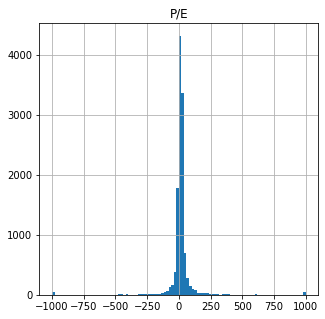

In [12]:
k=x.keys()[2] #14 max
x[k].hist(bins=100, figsize=(5,5))
plt.title(k);

In [13]:
x.describe()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
count,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000,12088.000000
mean,13.016235,0.207207,17.381071,4.077148,13.990528,26.270838,2.695140,0.067662,0.129202,2.387470,2.715851,1.365028,31.623771,0.467918,0.220722,-0.243144,0.039994,1.662915
std,65.259332,0.832561,115.282739,11.385424,70.599633,190.278783,2.938240,0.802910,0.169634,7.652083,3.085393,2.659149,195.968371,0.269949,0.259700,2.054084,0.235655,2.534020
min,-500.000000,-5.000000,-1000.000000,-50.000000,0.000069,-200.000000,0.000014,-5.000000,0.000000,0.000000,0.000000,0.000000,-7.372978,0.000000,-1.500000,-20.000000,-2.000000,-2.000000
25%,6.655097,0.055494,4.976717,1.469433,0.833230,-1.161608,1.225901,0.009011,0.030438,0.477849,1.440627,0.186360,2.318396,0.266191,0.045696,-0.085733,0.023154,0.440627
50%,13.015835,0.177975,17.285312,2.537091,1.718662,4.316344,1.868381,0.101943,0.096634,1.031258,1.858380,0.536135,5.824320,0.416789,0.188144,0.161141,0.072343,0.858380
75%,20.059873,0.360812,26.974545,4.541341,3.636853,15.169982,3.024420,0.191272,0.171114,1.984397,2.742205,1.352198,11.499286,0.643537,0.367065,0.415054,0.128559,1.742205
max,500.000000,5.000000,1000.000000,100.000000,500.000000,800.000000,30.000000,5.000000,2.000000,100.000000,50.000000,30.000000,2000.000000,3.000000,1.091673,2.000000,1.000000,20.000000


In [14]:
y

,Ticker,Perf
0,A,0.936104
1,A,0.373311
2,A,-0.036180
3,A,0.185295
4,A,0.416215
...,...,...
12083,low,0.517206
12084,low,0.018521
12085,low,0.096215
12086,low,0.029423


In [15]:
y.to_csv("Annual_Stock_Price_Performance_Percentage.csv")
x.to_csv("Annual_Stock_Price_Fundamentals_Ratios.csv")

### Try out power transformer see if our data has good distributions
A lot of the algorithms won't work without appropriate transformation. We'll use the power transformer

In [16]:
# Write code to plot out all distributions of X in a nice diagram
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer()
x_t=pd.DataFrame(transformer.fit_transform(x), columns=x.keys())

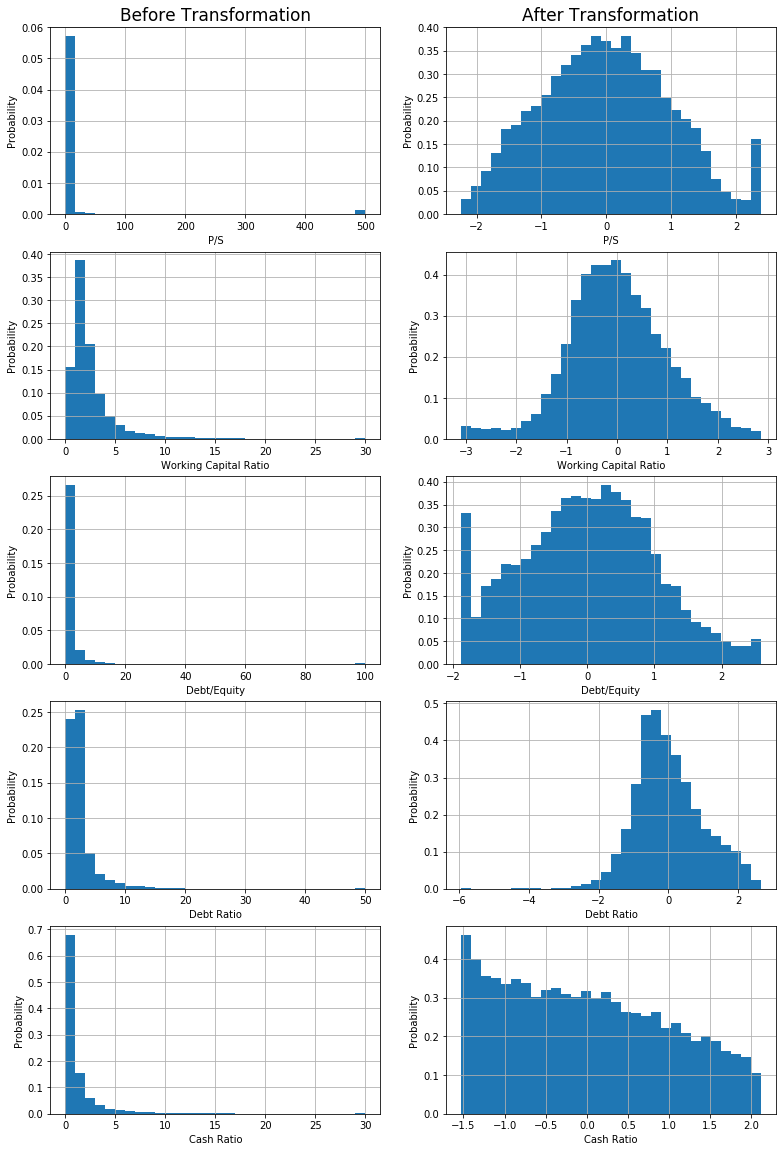

In [19]:
def plotFunc(n, myDatFrame):
    myKey = myDatFrame.keys()[n]
    plt.hist(myDatFrame[myKey], density=True, bins=30)
    plt.grid()
    plt.xlabel(myKey)
    plt.ylabel('Probability')

plt.figure(figsize=(13,20))
plotsIwant=[4,6,9,10,11]
j=1
for i in plotsIwant:
    plt.subplot(len(plotsIwant),2,2*j-1)
    plotFunc(i,x)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    plt.subplot(len(plotsIwant),2,2*j)
    plotFunc(i,x_t)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('Transformat_Dists.png', dpi=300)

# X Data for Final Stock Selection 2020
Requires SimFin+ Bulk Download

In [24]:
x_=pd.read_csv("Annual_Stock_Price_Fundamentals_Filtered_2020.csv", index_col=0)
x_['Net Income'] = x_['Net Income_x'] # Net Income fix, checked annual reports.
fixNansInX()
addColsToX()
x=getXRatios()
x=fixXRatios()
x.to_csv("Annual_Stock_Price_Fundamentals_Ratios_2020.csv")